In [51]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/media/beans/ssd/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
run_paths = glob.glob("/media/beans/ssd/blender_membank/*/run*", recursive=True)

In [53]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in range(115, 1160, 116)], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, run_path

((1160, 5),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 '/media/beans/ssd/blender_membank/dataloader_02/run_21')

In [54]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

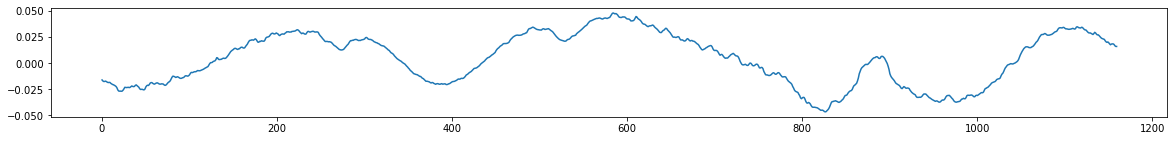

In [55]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

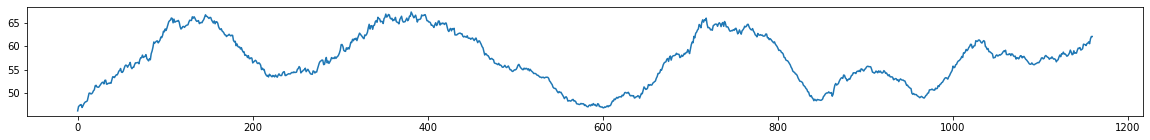

In [56]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [57]:
ix = 600

In [58]:
t = smooth_near_wps(targets[ix])

In [59]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [60]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

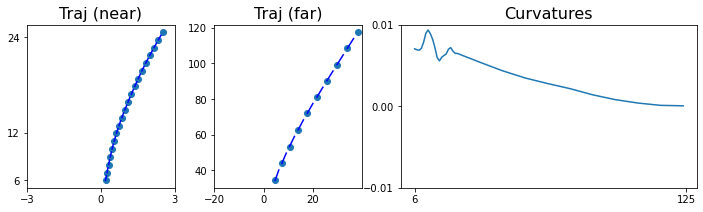

In [61]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

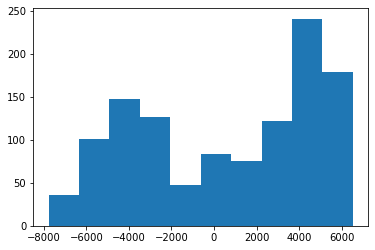

In [62]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

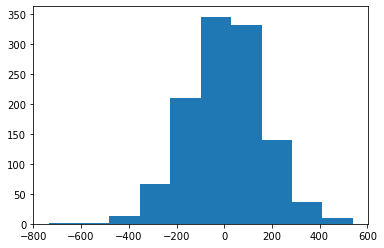

In [63]:
plt.hist(torque[1:]-torque[:-1])[2]

In [64]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [65]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    video.write(img)
    
video.release()

In [66]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)
imgs.shape, aux.shape

run_id = "sim"
model_stem = "7.19_avg"
make_vid(run_id, model_stem, imgs, aux, targets=targets, add_charts=False)

(1160, 30) (1160, 1, 13, 80) (1160, 1, 13, 80)
Made vid!


In [67]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([ 5.763257 ,  8.580333 , 10.240455 , 10.500037 ,  5.2888856,
        9.338992 ,  7.9391823,  7.764989 , 10.250727 , 11.319231 ,
        8.25393  ,  8.871372 ], dtype=float32)

In [87]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/media/beans/ssd/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in range(115, 1160, 116)]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


couldn't load 12 out of 360 runs


In [69]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 6.67 s, sys: 8.25 ms, total: 6.68 s
Wall time: 6.68 s


In [70]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [71]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((344, 1160, 30), (344, 1160, 30), (344, 1160, 30), (344, 1160, 30))

<BarContainer object of 40 artists>

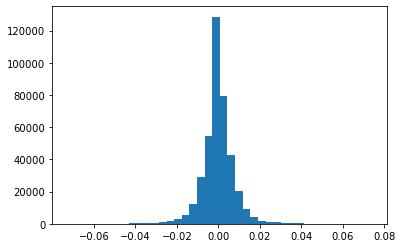

In [72]:
plt.hist(all_curvatures[:,:,2].flatten(), bins=40)[2]

In [73]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

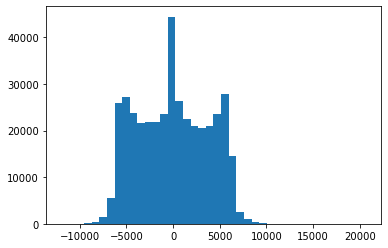

In [74]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

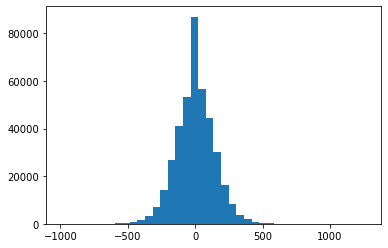

In [75]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [76]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(548.8242271723899, 9039.905397717508)

In [77]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  5.9956436,   6.994657 ,   7.993581 ,   8.9924135,   9.991143 ,
        10.989749 ,  11.988224 ,  12.986548 ,  13.984706 ,  14.982715 ,
        15.9805155,  16.978127 ,  17.975536 ,  18.972727 ,  19.969706 ,
        20.96646  ,  21.962944 ,  22.95921  ,  23.955217 ,  24.950985 ,
        34.89385  ,  44.80891  ,  54.6957   ,  64.55472  ,  74.38727  ,
        84.19562  ,  93.981735 , 103.74698  , 113.49162  , 123.21664  ],
      dtype=float32)

<BarContainer object of 40 artists>

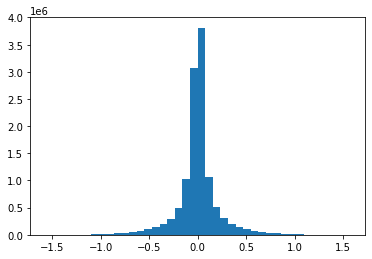

In [78]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [79]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.0288669 , 0.03337253, 0.03780214, 0.04223441, 0.04665006,
       0.0510548 , 0.05544036, 0.05978937, 0.0641369 , 0.06847604,
       0.07278395, 0.07705071, 0.08125976, 0.08541635, 0.08952025,
       0.09353136, 0.09744849, 0.10130709, 0.10514641, 0.10886998,
       0.14392936, 0.17571242, 0.20239767, 0.22382988, 0.2414611 ,
       0.2567455 , 0.27068812, 0.28332406, 0.29450393, 0.30095774],
      dtype=float32)

In [80]:
mean_headings[-1] / mean_headings[0]

10.425705

In [81]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01729074, 0.01909047, 0.0210426 , 0.02307848, 0.02516183,
       0.02727155, 0.02939828, 0.0315324 , 0.03366912, 0.03580829,
       0.03794599, 0.04008018, 0.04220656, 0.04432143, 0.04642246,
       0.04850852, 0.05057747, 0.05262937, 0.05466476, 0.05668471,
       0.07614999, 0.09413709, 0.11039608, 0.12479997, 0.13734631,
       0.14828952, 0.15799898, 0.16675799, 0.17472799, 0.18194672],
      dtype=float32)

In [82]:
mean_angles[-1] / mean_angles[0]

10.522782

In [83]:
mean_angles[0] / .015

1.1527162045240402

<BarContainer object of 40 artists>

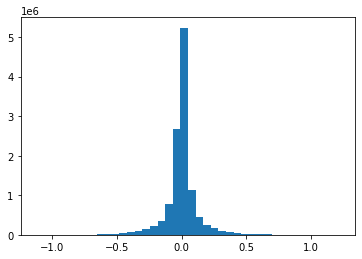

In [84]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

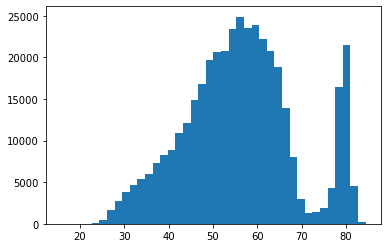

In [85]:
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]